In [6]:
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import glob
import pandas as pd
from scipy.io import arff
import logging
import os
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from sklearn.metrics import f1_score
from sklearn.model_selection import ParameterGrid
from tools.clustering.fuzzy_cmeans import FuzzyCMeansParamsGrid
from tools.clustering import PARAMS_GRID_MAP
from tools.config import DATA_DIR, CLUSTERED_DATA_DIR

# Set up logger
logger = logging.getLogger(__name__)

In [7]:
CLUSTERED_DATA_DIR
model_name = 'fuzzy_cmeans'
dataset_name = 'vowel'

In [8]:
SCRIPT_DIR = pathlib.Path(os.getcwd()).absolute()
DATA_DIR = os.path.join(SCRIPT_DIR.parent, "data")
PREPROCESSED_DATA_DIR = f'{DATA_DIR}/1_preprocessed/'

In [9]:
data_path = f"{DATA_DIR}/1_preprocessed/synthetic.csv"
df  = pd.read_csv(data_path)
df['class'].unique()


array([1, 2, 4, 3, 0])

In [138]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

METRICS_FILE_PATH = f"{DATA_DIR}/3_metrics.csv"
data = pd.read_csv(METRICS_FILE_PATH)

# Ensure numerical columns are properly parsed (if needed)
# data['runtime'] = pd.to_numeric(data['runtime'], errors='coerce')
# data['ari'] = pd.to_numeric(data['ari'], errors='coerce')
# data['purity'] = pd.to_numeric(data['purity'], errors='coerce')
# data['dbi'] = pd.to_numeric(data['dbi'], errors='coerce')
# data['f_measure'] = pd.to_numeric(data['f_measure'], errors='coerce')

data[data['dataset'] == 'mushroom'][data['model'] == 'fuzzy_cmeans'][data['n_clusters'] == 2]

/tmp/ipykernel_144851/1118703523.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data[data['dataset'] == 'mushroom'][data['model'] == 'fuzzy_cmeans'][data['n_clusters'] == 2]
/tmp/ipykernel_144851/1118703523.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data[data['dataset'] == 'mushroom'][data['model'] == 'fuzzy_cmeans'][data['n_clusters'] == 2]


,dataset,model,runtime,dbi,chi,ari,f_measure,n_clusters,fuzzyness,max_iterations,...,max_depth,metric,algorithm,min_samples,xi,min_cluster_size,n_neighbors,affinity,eigen_solver,assign_labels
961,mushroom,fuzzy_cmeans,0.132461,2.808719,984.595671,0.600548,0.887184,2.0,1.5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
962,mushroom,fuzzy_cmeans,0.199084,2.810931,984.293029,0.605136,0.888682,2.0,2.5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
963,mushroom,fuzzy_cmeans,0.119384,3.478447,666.685647,0.013959,0.559084,2.0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
964,mushroom,fuzzy_cmeans,0.149267,1.854090,1295.423663,0.212442,0.702997,2.0,3.5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
965,mushroom,fuzzy_cmeans,0.098206,1.854090,1295.423663,0.212442,0.702997,2.0,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
966,mushroom,fuzzy_cmeans,0.196777,2.683925,1072.226462,0.748343,0.931844,2.0,4.5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
967,mushroom,fuzzy_cmeans,0.171795,1.857471,1294.417394,0.213353,0.703638,2.0,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
968,mushroom,fuzzy_cmeans,0.135145,1.862484,1292.859287,0.214724,0.704599,2.0,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
def plot_model_comparisons(data, metric, title):
    """
    Plot comparisons of models across datasets based on a given metric.
    
    Args:
        data (pd.DataFrame): The dataset containing performance metrics.
        metric (str): The metric to visualize (e.g., 'ari', 'purity').
        title (str): Title of the plot.
    """
    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=data, 
        x='dataset', 
        y=metric, 
        hue='model', 
        ci='sd', 
        palette='viridis'
    )
    plt.title(title, fontsize=14)
    plt.xlabel('Dataset', fontsize=12)
    plt.ylabel(metric.capitalize(), fontsize=12)
    plt.legend(title='Model', fontsize=10, loc='best')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()



In [12]:
def plot_heatmaps(data):
    pivot_table = data.pivot_table(
        index='model', columns='dataset', values='ari', aggfunc='mean'
    )
    sns.heatmap(pivot_table, annot=True, cmap='coolwarm')
    plt.title('ARI Heatmap Across Models and Datasets')
    plt.show()

# plot_heatmaps(data)

In [13]:
def plot_combined_heatmaps(data, metrics, datasets, models):
    """
    Generate a grid of heatmaps (e.g., 2x2) for multiple metrics.
    
    Args:
        data (pd.DataFrame): The dataset containing performance metrics.
        metrics (list): List of metrics to plot heatmaps for.
        datasets (list): List of dataset names.
        models (list): List of model names.
    """
    n_metrics = len(metrics)
    n_cols = 2  # Number of columns for the heatmap grid
    n_rows = (n_metrics + n_cols - 1) // n_cols  # Calculate rows needed
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 6 * n_rows), constrained_layout=True)
    
    # Flatten axes to easily iterate over them, even for 2D array
    axes = axes.flatten()
    
    for i, metric in enumerate(metrics):
        # Pivot table for the heatmap
        pivot_table = data.pivot_table(
            index='model', columns='dataset', values=metric, aggfunc='mean'
        ).reindex(index=models, columns=datasets)  # Ensure consistent order
        
        # Plot the heatmap on the respective subplot
        sns.heatmap(
            pivot_table,
            ax=axes[i],
            annot=True,
            cmap='coolwarm',
            cbar=True,
            linewidths=0.5,
            fmt=".2f",
        )
        axes[i].set_title(f'Heatmap for {metric.capitalize()}', fontsize=14)
        axes[i].set_xlabel('Dataset', fontsize=12)
        axes[i].set_ylabel('Model', fontsize=12)
    
    # Hide any unused subplots (in case metrics < n_rows * n_cols)
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.show()

# Example usage:
# Define the metrics, datasets, and models to compare
metrics = ['ari', 'purity', 'dbi', 'f_measure']
datasets = data['dataset'].unique()
models = data['model'].unique()

# Generate the combined heatmaps
# plot_combined_heatmaps(data, metrics, datasets, models)


In [14]:

def plot_pairplot(data):
    sns.pairplot(data, vars=['ari', 'purity', 'dbi', 'f_measure'], hue='model')
    plt.show()

# plot_pairplot(data)

In [15]:
# Compare ARI
# plot_model_comparisons(data, 'ari', 'Comparison of ARI Across Models and Datasets')

In [16]:
# Compare Purity
# plot_model_comparisons(data, 'purity', 'Comparison of Purity Across Models and Datasets')



In [17]:
# Compare Runtime
# plot_model_comparisons(data, 'runtime', 'Comparison of Runtime Across Models and Datasets')


In [18]:
def compare_clustering_params(data):
    g = sns.catplot(
        data=data, 
        x='n_clusters', 
        y='ari', 
        hue='model', 
        col='dataset', 
        kind='bar', 
        palette='viridis'
    )
    g.set_titles("{col_name}")
    g.set_axis_labels("Number of Clusters", "ARI")
    plt.show()

# compare_clustering_params(data)

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_radar_chart(data, dataset_name, metrics, models):
    """
    Generate radar chart to visualize multiple metrics for each model.
    
    Args:
        data (pd.DataFrame): The dataset containing performance metrics.
        dataset_name (str): The name of the dataset to filter by.
        metrics (list): List of metrics to include in the radar chart.
        models (list): List of models to compare.
    """
    # Filter data for the selected dataset
    subset = data[data['dataset'] == dataset_name]
    
    # Normalize metrics to make them comparable (optional but recommended)
    normalized_data = subset.copy()
    for metric in metrics:
        max_value = subset[metric].max()
        min_value = subset[metric].min()
        normalized_data[metric] = (subset[metric] - min_value) / (max_value - min_value)
    
    # Prepare data for radar chart
    angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
    angles += angles[:1]  # Complete the circle

    plt.figure(figsize=(8, 8))
    
    for model in models:
        model_data = normalized_data[normalized_data['model'] == model]
        if not model_data.empty:
            # Extract metric values
            values = model_data[metrics].mean().tolist()
            values += values[:1]  # Complete the circle
            
            # Plot data
            plt.polar(angles, values, label=model)
    
    # Draw one axis per metric
    plt.xticks(angles[:-1], metrics, fontsize=12)
    
    # Add legend and title
    plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
    plt.title(f'Radar Chart for {dataset_name}', fontsize=15)
    
    # Show plot
    plt.show()

# Example usage:
# Define the metrics and models to compare
metrics = ['ari', 'purity', 'dbi', 'f_measure', 'runtime']
models = ['fuzzy_cmeans', 'kmeans', 'gmeans']

# Generate radar chart for each dataset
datasets = data['dataset'].unique()
# for dataset in datasets:
#     plot_radar_chart(data, dataset, metrics, models)


In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_model_performance(data, model_name, metrics, datasets, plot_type="bar", save_path=None):
    """
    Generate plots to visualize the performance of a specific model across datasets and metrics.
    
    Args:
        data (pd.DataFrame): The dataset containing performance metrics.
        model_name (str): The name of the model to analyze.
        metrics (list): List of metrics to visualize.
        datasets (list): List of dataset names to include.
        plot_type (str): Type of plot ('bar', 'radar', 'line').
        save_path (str or None): File path to save the figure. If None, the plot is displayed.
    """
    # Filter data for the specific model
    subset = data[data['model'] == model_name]
    
    # Extract values for the metrics
    performance_data = subset.pivot(index='dataset', columns='metric', values=metrics).reindex(datasets)
    
    if plot_type == "bar":
        # Bar Plot: Metrics for a model across datasets
        performance_data.plot(kind='bar', figsize=(12, 8), rot=0)
        plt.title(f"Performance of {model_name} Across Datasets", fontsize=16)
        plt.xlabel("Dataset", fontsize=14)
        plt.ylabel("Metric Values", fontsize=14)
        plt.legend(title="Metrics", fontsize=12)

    elif plot_type == "radar":
        # Radar Chart: Metrics for a model across datasets
        angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
        angles += angles[:1]  # Complete the circle

        fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
        for dataset in datasets:
            values = performance_data.loc[dataset].tolist()
            values += values[:1]  # Complete the circle
            ax.plot(angles, values, label=dataset)
            ax.fill(angles, values, alpha=0.1)

        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(metrics)
        ax.set_title(f"Radar Chart for {model_name}", fontsize=16)
        ax.legend(loc="upper right", bbox_to_anchor=(1.2, 1.1))

    elif plot_type == "line":
        # Line Plot: Metrics for a model across datasets
        performance_data.plot(kind='line', marker='o', figsize=(12, 8))
        plt.title(f"Performance of {model_name} Across Datasets", fontsize=16)
        plt.xlabel("Dataset", fontsize=14)
        plt.ylabel("Metric Values", fontsize=14)
        plt.legend(title="Metrics", fontsize=12)

    else:
        raise ValueError("Invalid plot_type. Choose from 'bar', 'radar', or 'line'.")

    # Save or display the plot
    if save_path:
        plt.savefig(save_path, format='png', dpi=300)
        print(f"Figure saved to {save_path}")
    else:
        plt.show()

In [21]:
# Example usage:
# Define parameters
model_name = "fuzzy_cmeans"  # The model to analyze
metrics = ['ari', 'purity', 'dbi', 'f_measure', 'runtime']  # Metrics to include
datasets = data['dataset'].unique()  # Datasets to include

# Bar Plot
# plot_model_performance(data, model_name, metrics, datasets, plot_type="bar")

# Radar Chart
# plot_model_performance(data, model_name, metrics, datasets, plot_type="radar")

# Line Plot
# plot_model_performance(data, model_name, metrics, datasets, plot_type="line")


Pairplot saved to fuzzy_cmeans_pairplot.png


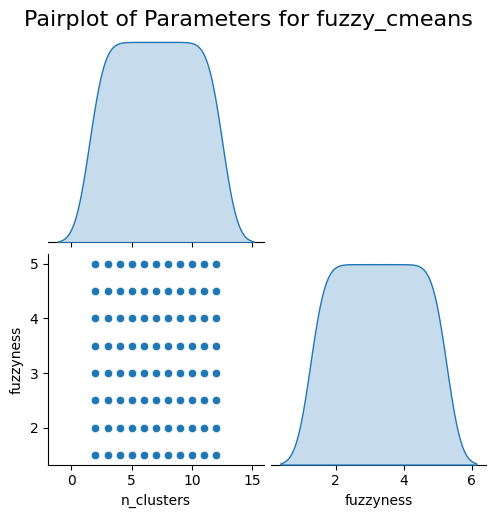

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_model_parameters_pairplot(data, model_name, parameters, save_path=None):
    """
    Generate a pairplot comparing a model's parameters.
    
    Args:
        data (pd.DataFrame): The dataset containing model parameters.
        model_name (str): The name of the model to analyze.
        parameters (list): List of parameter columns to include in the pairplot.
        save_path (str or None): File path to save the figure. If None, the plot is displayed.
    """
    # Filter data for the specific model
    subset = data[data['model'] == model_name]
    
    # Select only the specified parameter columns
    if not set(parameters).issubset(data.columns):
        raise ValueError("One or more specified parameters are not present in the dataset.")
    
    param_data = subset[parameters]
    
    # Create the pairplot
    pairplot = sns.pairplot(param_data, diag_kind='kde', corner=True)
    pairplot.fig.suptitle(f"Pairplot of Parameters for {model_name}", y=1.02, fontsize=16)
    
    # Save or display the plot
    if save_path:
        pairplot.savefig(save_path, format='png', dpi=300)
        print(f"Pairplot saved to {save_path}")
    else:
        plt.show()

# Example usage:
# Define parameters for fuzzy_cmeans
model_name = "fuzzy_cmeans"
parameters = ['n_clusters', 'fuzzyness']  # Include relevant columns

# Plot pairplot
plot_model_parameters_pairplot(data, model_name, parameters, save_path="fuzzy_cmeans_pairplot.png")


Pairplot saved to fuzzy_cmeans_metric_pairplot.png


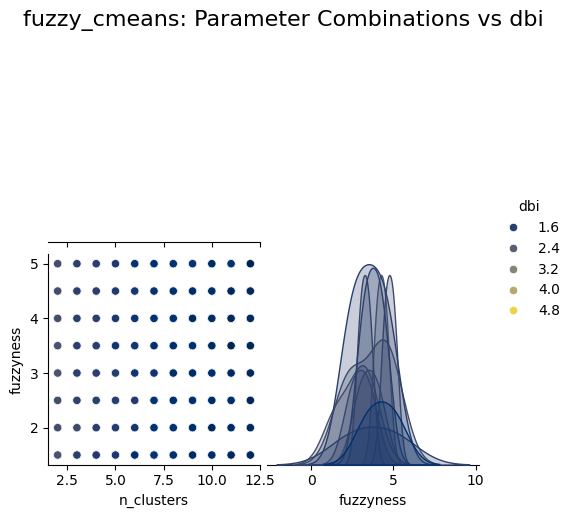

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_parameters_vs_metric_pairplot(data, model_name, parameters, metric, save_path=None):
    """
    Generate a pairplot comparing a model's parameters, with a metric as the hue.
    
    Args:
        data (pd.DataFrame): The dataset containing model parameters and metrics.
        model_name (str): The name of the model to analyze.
        parameters (list): List of parameter columns to include in the pairplot.
        metric (str): The metric column to use as the hue.
        save_path (str or None): File path to save the figure. If None, the plot is displayed.
    """
    # Filter data for the specific model
    subset = data[data['model'] == model_name]
    
    # Ensure the specified columns exist in the dataset
    if not set(parameters + [metric]).issubset(data.columns):
        raise ValueError("One or more specified parameters or metric are not present in the dataset.")
    
    # Select parameters and metric
    param_data = subset[parameters + [metric]]
    
    # Create the pairplot with the metric as the hue
    pairplot = sns.pairplot(param_data, diag_kind='kde', hue=metric, corner=True, palette="cividis")
    pairplot.fig.suptitle(f"{model_name}: Parameter Combinations vs {metric}", y=1.02, fontsize=16)
    
    # Save or display the plot
    if save_path:
        pairplot.savefig(save_path, format='png', dpi=300)
        print(f"Pairplot saved to {save_path}")
    else:
        plt.show()

# Example usage:
# Define parameters and metric for fuzzy_cmeans
model_name = "fuzzy_cmeans"
parameters = ['n_clusters', 'fuzzyness']  # Include relevant columns
metric = 'dbi'  # Metric to analyze

# Plot pairplot
plot_parameters_vs_metric_pairplot(data, model_name, parameters, metric, save_path=f"fuzzy_cmeans_metric_pairplot.png")


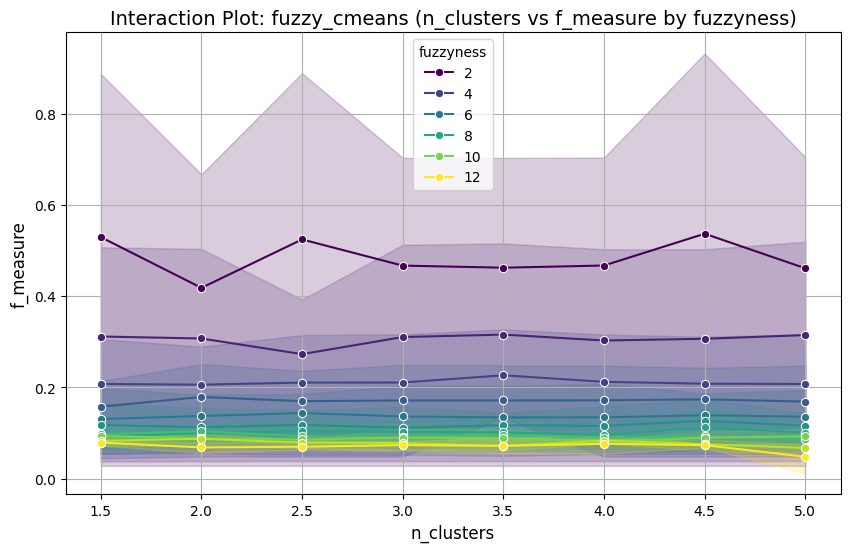

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_interaction(data, model_name, param_x, param_y, metric, save_path=None):
    """
    Create an interaction plot to show the relationship between two parameters
    and their effect on a metric for a specific model.
    
    Args:
        data (pd.DataFrame): The dataset containing parameters and metrics.
        model_name (str): The name of the model to analyze.
        param_x (str): The parameter for the x-axis.
        param_y (str): The parameter to interact with (grouped or categorized).
        metric (str): The metric to analyze.
        save_path (str or None): Path to save the plot. If None, the plot is displayed.
    """
    # Filter the data for the selected model
    subset = data[data['model'] == model_name]
    
    # Ensure the specified columns exist in the dataset
    if not set([param_x, param_y, metric]).issubset(data.columns):
        raise ValueError("One or more specified parameters or metric are not present in the dataset.")
    
    # Create the interaction plot
    plt.figure(figsize=(10, 6))
    sns.lineplot(
        data=subset,
        x=param_y,
        y=metric,
        hue='n_clusters',
        marker="o",
        palette="viridis"
    )
    
    # Add labels and title
    plt.title(f"Interaction Plot: {model_name} ({param_x} vs {metric} by {param_y})", fontsize=14)
    plt.xlabel(param_x, fontsize=12)
    plt.ylabel(metric, fontsize=12)
    plt.legend(title=param_y, fontsize=10)
    plt.grid(True)
    
    # Save or display the plot
    if save_path:
        plt.savefig(save_path, format='png', dpi=300)
        print(f"Interaction plot saved to {save_path}")
    else:
        plt.show()

# Example usage:
# Parameters and metric to analyze for fuzzy_cmeans
model_name = "fuzzy_cmeans"
param_x = "n_clusters"  # X-axis parameter
param_y = "fuzzyness"   # Grouping parameter
metric = "f_measure"    # Metric to evaluate

# Generate interaction plot
plot_interaction(data, model_name, param_x, param_y, metric, save_path=None)


In [25]:
# !pip install pypalettes

In [26]:
metrics.remove('ari')


In [27]:
# create a color palette
from pypalettes import load_cmap

alexandrite = load_cmap("Alexandrite")
emrld = load_cmap("Emrld", reverse=True)
colors = alexandrite.colors
plt.style.use("default")

In [110]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def custom_boxplot(ax, data):
    print('boxplot data', data[0])
    ax.boxplot(
        data,
        patch_artist=True,  # Fill boxes with color
        medianprops={"color": "blue", "linewidth": 2},  # Style median lines
        flierprops={
            "marker": "o",
            "markerfacecolor": "red",
            "markeredgewidth": 1,
            "markersize": 4,
        },  # Style outlier points
        boxprops={"facecolor": "lightblue", "alpha": 0.7},  # Style boxes
        whiskerprops={"linestyle": "--"},  # Style whiskers
        capprops={"linewidth": 2},  # Style caps
    )
    ax.yaxis.grid(True, linestyle="--", alpha=0.7)
    ax.set_axisbelow(True)  # Put grid behind plot elements
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

def plot_interactions_across_datasets(df, col_names, datasets, model_name):
    num_cols = len(col_names)
    num_datasets = len(datasets)
    total_cols = num_cols * num_datasets
    fig, axes = plt.subplots(
        num_cols, total_cols, figsize=(12 * num_datasets, 8 * num_cols), squeeze=False
    )

    print('axes', axes.flatten().shape)


    for dataset_idx, dataset_name in enumerate(datasets):

        for i, ((col_name1, col_name2), ax) in enumerate(
            zip(itertools.product(col_names, repeat=2), axes.flatten())
        ):
            # Skip plots above diagonal
            row = i // num_cols
            col = i % total_cols
            if col > row:
                print('skipping', row, col)
                ax.set_visible(False)
                continue
            
            print(col_name1, col_name2)
            print('idx', i, dataset_idx+i)
            # ax = axes[i, dataset_idx+num_cols]
            filtered_df = df[(df['dataset'] == dataset_name) & (df['model'] == model_name)]


            if col_name1 == col_name2:
                
                # Diagonal-like plots: Distribution for a single variable
                unique_vals = filtered_df[col_name1].unique()
                if np.issubdtype(unique_vals.dtype, np.number):
                    unique_vals.sort()
                sorted_data = [
                    filtered_df[filtered_df[col_name1] == val]["f_measure"].tolist()
                    for val in unique_vals
                ]
                print(f'custom boxplot of {col_name1} in {dataset_name}')
                print()
                custom_boxplot(ax, sorted_data)
            else:
                # Off-diagonal: Heatmap for interactions
                pivot_table = filtered_df.pivot_table(
                    values="f_measure", index=col_name1, columns=col_name2, aggfunc="mean"
                )
                sns.heatmap(
                    pivot_table,
                    ax=ax,
                    cmap=emrld,
                    annot=True,
                    fmt=".2f",
                    cbar=False,
                )

                print('off diagonal', col_name1, col_name2)
                print()

            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_xlabel("")
            ax.set_ylabel("")

            # Add titles and adjust ticks
            if i % 2 == 0:  # Top row, label with dataset names
                ax.set_title(dataset_name, fontsize=14, fontweight="bold")
            if dataset_idx == 0:  # First column, label with param names
                ax.set_ylabel(col_name1, fontsize=12, rotation=90)

    # Add row labels and y-ticks only on the leftmost plots
    # for i in range(num_cols):
    #     axes[i, dataset_idx].set_ylabel(col_names[i], fontsize=20, rotation=90)
    #     if i > 0:
    #         unique_vals = (
    #             sorted(df[col_names[i]].unique())
    #             if pd.api.types.is_numeric_dtype(df[col_names[i]])
    #             else df[col_names[i]].unique()
    #         )
    #         axes[i, dataset_idx+num_cols].set_yticks(np.arange(len(unique_vals)) + 0.5)
    #         axes[i, dataset_idx+num_cols].set_yticklabels(unique_vals, rotation=15)

    # # Add column labels and x-ticks only on the bottom plots
    # for j in range(num_datasets):
    #     unique_vals = (
    #         sorted(df[col_names[j]].unique())
    #         if pd.api.types.is_numeric_dtype(df[col_names[j]])
    #         else df[col_names[j]].unique()
    #     )
    #     if j == num_cols - 1:
    #         axes[-1, j].set_xticks(np.arange(len(unique_vals)) + 1)
    #     else:
    #         axes[-1, j].set_xticks(np.arange(len(unique_vals)) + 0.5)
    #     axes[-1, j].set_xticklabels(unique_vals, rotation=15)
    #     axes[-1, j].set_xlabel(col_names[j], fontsize=20, labelpad=20)


    plt.tight_layout()
    return fig


In [184]:
model_name = 'fuzzy_cmeans'

In [185]:
models

['fuzzy_cmeans', 'kmeans', 'gmeans']

In [186]:
# data_for_method = data[data['model'] == model_name] 
params_for_method = list(PARAMS_GRID_MAP[model_name].keys())
datasets, params_for_method

(array(['hepatitis', 'mushroom', 'vowel'], dtype=object),
 ['n_clusters', 'fuzzyness'])

In [187]:
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

def plot_interactions_with_gridspec(df, col_names, datasets, model_name):
    num_cols = len(col_names)
    total_datasets = len(datasets)

    # Create the main figure and grid for datasets
    fig = plt.figure(figsize=(15 * total_datasets, 6 * num_cols))
    outer_grid = GridSpec(1, total_datasets, figure=fig, wspace=0.1)

    # Prepare a placeholder for the colorbar data
    heatmap_min, heatmap_max = np.inf, -np.inf

    for dataset_idx, dataset_name in enumerate(datasets):
        # Create a sub-grid for each dataset within the main grid
        inner_grid = GridSpecFromSubplotSpec(
            num_cols, num_cols, subplot_spec=outer_grid[dataset_idx],
        )

        filtered_df = df[(df['dataset'] == dataset_name) & (df['model'] == model_name)]
        axes = []

        for i, ((col_name1, col_name2), inner_idx) in enumerate(
            zip(itertools.product(col_names, repeat=2), range(num_cols * num_cols))
        ):
            row = inner_idx // num_cols
            col = inner_idx % num_cols

            ax = fig.add_subplot(inner_grid[row, col])
            axes.append(ax)


            # Skip plots above the diagonal
            if col > row:
                ax.axis("off")
                continue

            

            if col_name1 == col_name2:
                # Diagonal-like plots: Single-variable distribution (boxplot)
                unique_vals = filtered_df[col_name1].unique()
            
                if np.issubdtype(unique_vals.dtype, np.number):
                    unique_vals.sort()
                    
                sorted_data = [
                    filtered_df[filtered_df[col_name1] == val]["f_measure"].tolist()
                    for val in unique_vals
                ]
                
                custom_boxplot(ax, sorted_data)
                
                ax.set_xticklabels(unique_vals)
                ax.set_xlabel(f"{col_name1}", fontsize=10)
                ax.set_ylabel("F1 measure", fontsize=10)
                # ax.set_title(f"{col_name1}", fontsize=10)
            else:
                # Off-diagonal: Interaction heatmap
                pivot_table = filtered_df.pivot_table(
                    values="f_measure", index=col_name1, columns=col_name2, aggfunc="mean"
                )
                sns.heatmap(
                    pivot_table,
                    ax=ax,
                    cmap="viridis",
                    annot=False,
                    # fmt=".2f",
                    cbar=False,
                )
                # ax.set_title(f"{col_name1} vs {col_name2}", fontsize=8)

                # Update the global min and max for the colorbar
                if pivot_table.values.size > 0:  # Check if pivot_table is not empty
                    heatmap_min = min(heatmap_min, np.nanmin(pivot_table.values))
                    heatmap_max = max(heatmap_max, np.nanmax(pivot_table.values))

            # Style: Remove ticks for clarity
            # ax.set_xticks([])
            # ax.set_yticks([])

        # Add a title for the entire dataset grid
        inner_title = fig.add_subplot(outer_grid[dataset_idx])
        inner_title.axis("off")
        inner_title.set_title(dataset_name, fontsize=14, fontweight="bold")

    
    # # Add row labels and y-ticks only on the leftmost plots
    # for i in range(num_cols):
    #     if i < len(axes) and axes[i * num_cols]:  # Check if the subplot exists
    #         axes[i * num_cols].set_ylabel(col_names[i], fontsize=12, rotation=90)
    #         unique_vals = (
    #             sorted(filtered_df[col_names[i]].unique())
    #             if pd.api.types.is_numeric_dtype(filtered_df[col_names[i]])
    #             else filtered_df[col_names[i]].unique()
    #         )
    #         axes[i * num_cols].set_yticks(np.arange(len(unique_vals)) + 0.5)
    #         axes[i * num_cols].set_yticklabels(unique_vals, rotation=15)

    # # Add column labels and x-ticks only on the bottom plots
    # for j in range(num_cols):
    #     if (num_cols - 1) * num_cols + j < len(axes):  # Check if the subplot exists
    #         unique_vals = (
    #             sorted(filtered_df[col_names[j]].unique())
    #             if pd.api.types.is_numeric_dtype(filtered_df[col_names[j]])
    #             else filtered_df[col_names[j]].unique()
    #         )
    #         axes[(num_cols - 1) * num_cols + j].set_xticks(np.arange(len(unique_vals)) + 0.5)
    #         axes[(num_cols - 1) * num_cols + j].set_xticklabels(unique_vals, rotation=15)
    #         axes[(num_cols - 1) * num_cols + j].set_xlabel(col_names[j], fontsize=12)



    cbar_ax = fig.add_axes([0.92, 0.15, 0.01, 0.75])  # [left, bottom, width, height]
    norm = plt.Normalize(heatmap_min, heatmap_max)
    sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
    sm.set_array([])
    fig.colorbar(sm, cax=cbar_ax, label="F1 Score", orientation="vertical")

    
    # Add a global title for the entire plot
    fig.suptitle(f'Interaction Effects of {model_name} Parameters Across Datasets', fontsize=18, fontweight="bold")
    # fig.tight_layout()
    return fig


boxplot data [0.6728577458843394, 0.655937846836848, 0.6671956684092606, 0.655937846836848, 0.6695722203799328, 0.6503383822107638, 0.6695722203799328, 0.6503383822107638]
boxplot data [0.0839246119733924, 0.0714285714285714, 0.0723226049313005, 0.6728577458843394, 0.3896103896103896, 0.2723316536875859, 0.2136517328825021, 0.1392107784061061, 0.1227166276346604, 0.1019463087248322, 0.1129343629343629]
boxplot data [0.8871836384934797, 0.8886818644594594, 0.559084105226314, 0.7029972242131595, 0.7029972242131595, 0.9318443855212154, 0.7036383558715057, 0.7045989617498782]
boxplot data [0.0970389932087, 0.0847861692438502, 0.0815115316415268, 0.8871836384934797, 0.5069315155573019, 0.3055760033841342, 0.2048843199185356, 0.1980715989014319, 0.1635745830671639, 0.1090756884824986, 0.1029855969386836]
boxplot data [0.0279557926244291, 0.0279557926244291, 0.0279557926244291, 0.0279557926244291, 0.0279557926244291, 0.0279557926244291, 0.0279557926244291, 0.0279557926244291]
boxplot data [0.

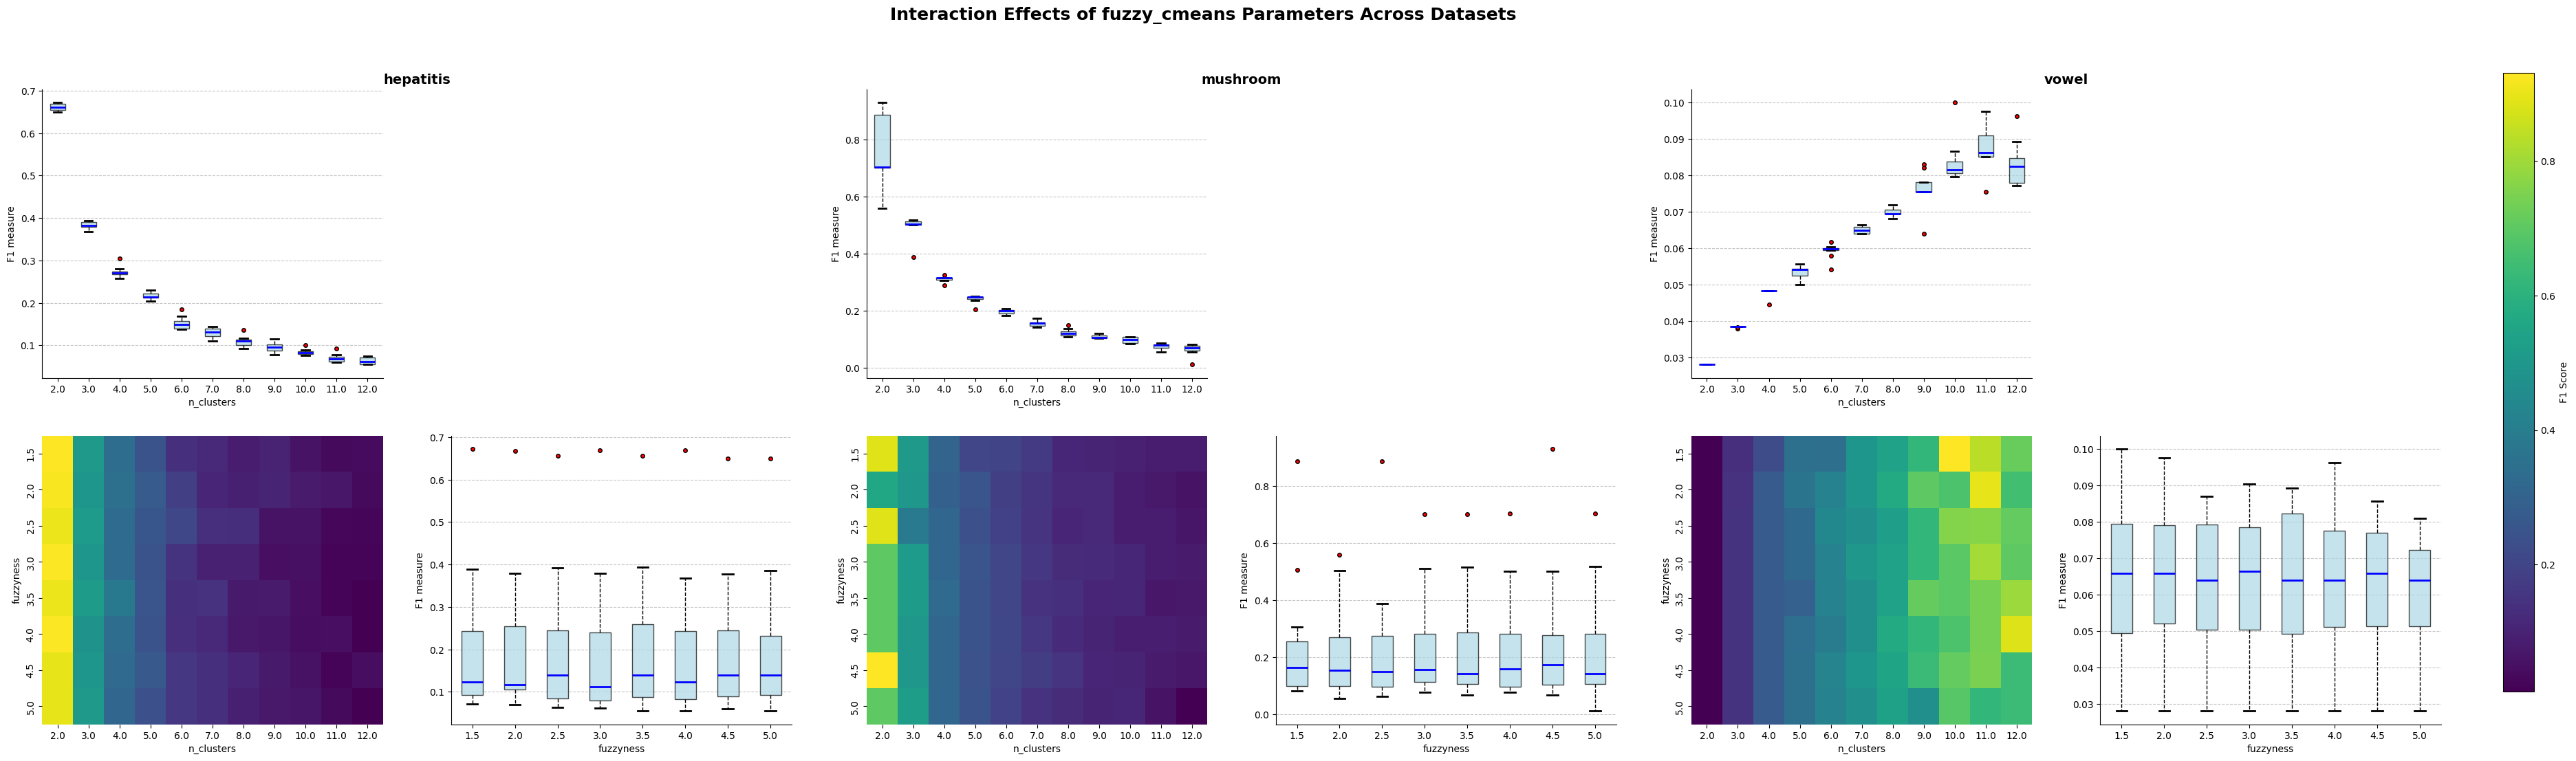

In [188]:
fig = plot_interactions_with_gridspec(
    data,
    params_for_method,
    datasets,
    model_name
)
# fig.suptitle('Interaction Effects of Fu Model Parameters on F1 Score', fontsize=20, fontweight='bold')
# fig.subplots_adjust(top=0.95)
# fig.savefig('../reports/figures/interaction_effects_KNN.png', dpi=300)
plt.show()